In [40]:
import os,sys,json
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn import model_selection as md
from keras import regularizers
import numpy as np
from collections import Counter

In [30]:
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        
##############################################################

def balanced_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}


#############################################################

######################################################################
def HSC_Subaru_CNN(args):
    
    dx,dy,nChannels = args
    
    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    #x = Dropout(0.5,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    #x = Dropout(0.25,name='Drop_C2')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(2,2),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    #x = Dropout(0.25,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    # x = Dropout(0.25,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(64,activation='relu',name='Dense_1')(x)
    x = Dropout(0.25,name='DropFCL_1')(x)
    x = Dense(16,activation='relu',name='Dense_2')(x)
    x = Dropout(0.25,name='DropFCL_2')(x)
    x = Dense(1,activation='sigmoid',name='Dense_3')(x)

    # connect and compile
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=keras.optimizers.Adadelta(), 
                  loss='binary_crossentropy',metrics=['accuracy'])
    return model
######################################################################

In [37]:
classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
fileNames = ['{}{}_grizy_Images-AugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}Negative_grizy_Images_cat.npy'.format(dataDir),'{}Positive_grizy_Images-Aug_cat.npy'.format(dataDir)]

tar = np.array([])
inp = np.array([])
# Negatives
inp_neg = np.load(fileNames[0])[:,:,:,2]
inp_neg[np.isnan(inp_neg)]=0.
# inp_neg = np.zeros(shape=(20010,128,128)) # !!! for testing
cat_neg = np.load(catNames[0])
tar_neg = np.append(tar,np.ones(inp_neg.shape[0])*0)
# Positives
inp_pos = np.load(fileNames[1])[:1201,:,:,2]
#inp_pos = np.ones(shape=(20417,128,128)) # !!! for testing
# inp_pos[:,48:80,48:80] = 1. # !!! for testing
cat_pos = np.load(catNames[1])[:1201]
tar_pos = np.ones(inp_pos.shape[0])[:1201]
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0)
cat = np.concatenate([cat_neg,cat_pos],axis=0)
tar = np.append(tar_neg,tar_pos)
# Reformatting
#tar_OH = keras.utils.to_categorical(tar)
inp = inp.reshape((*inp.shape,1))

In [45]:
inp = np.concatenate([inp_neg[:5000],inp_pos],axis=0)
cat = np.concatenate([cat_neg[:5000],cat_pos],axis=0)
tar = np.append(tar_neg[:5000],tar_pos)
inp = inp.reshape((*inp.shape,1))

Negatives
(21211, 128, 128, 1) 20010
Positives
(21211, 128, 128, 1) 1201


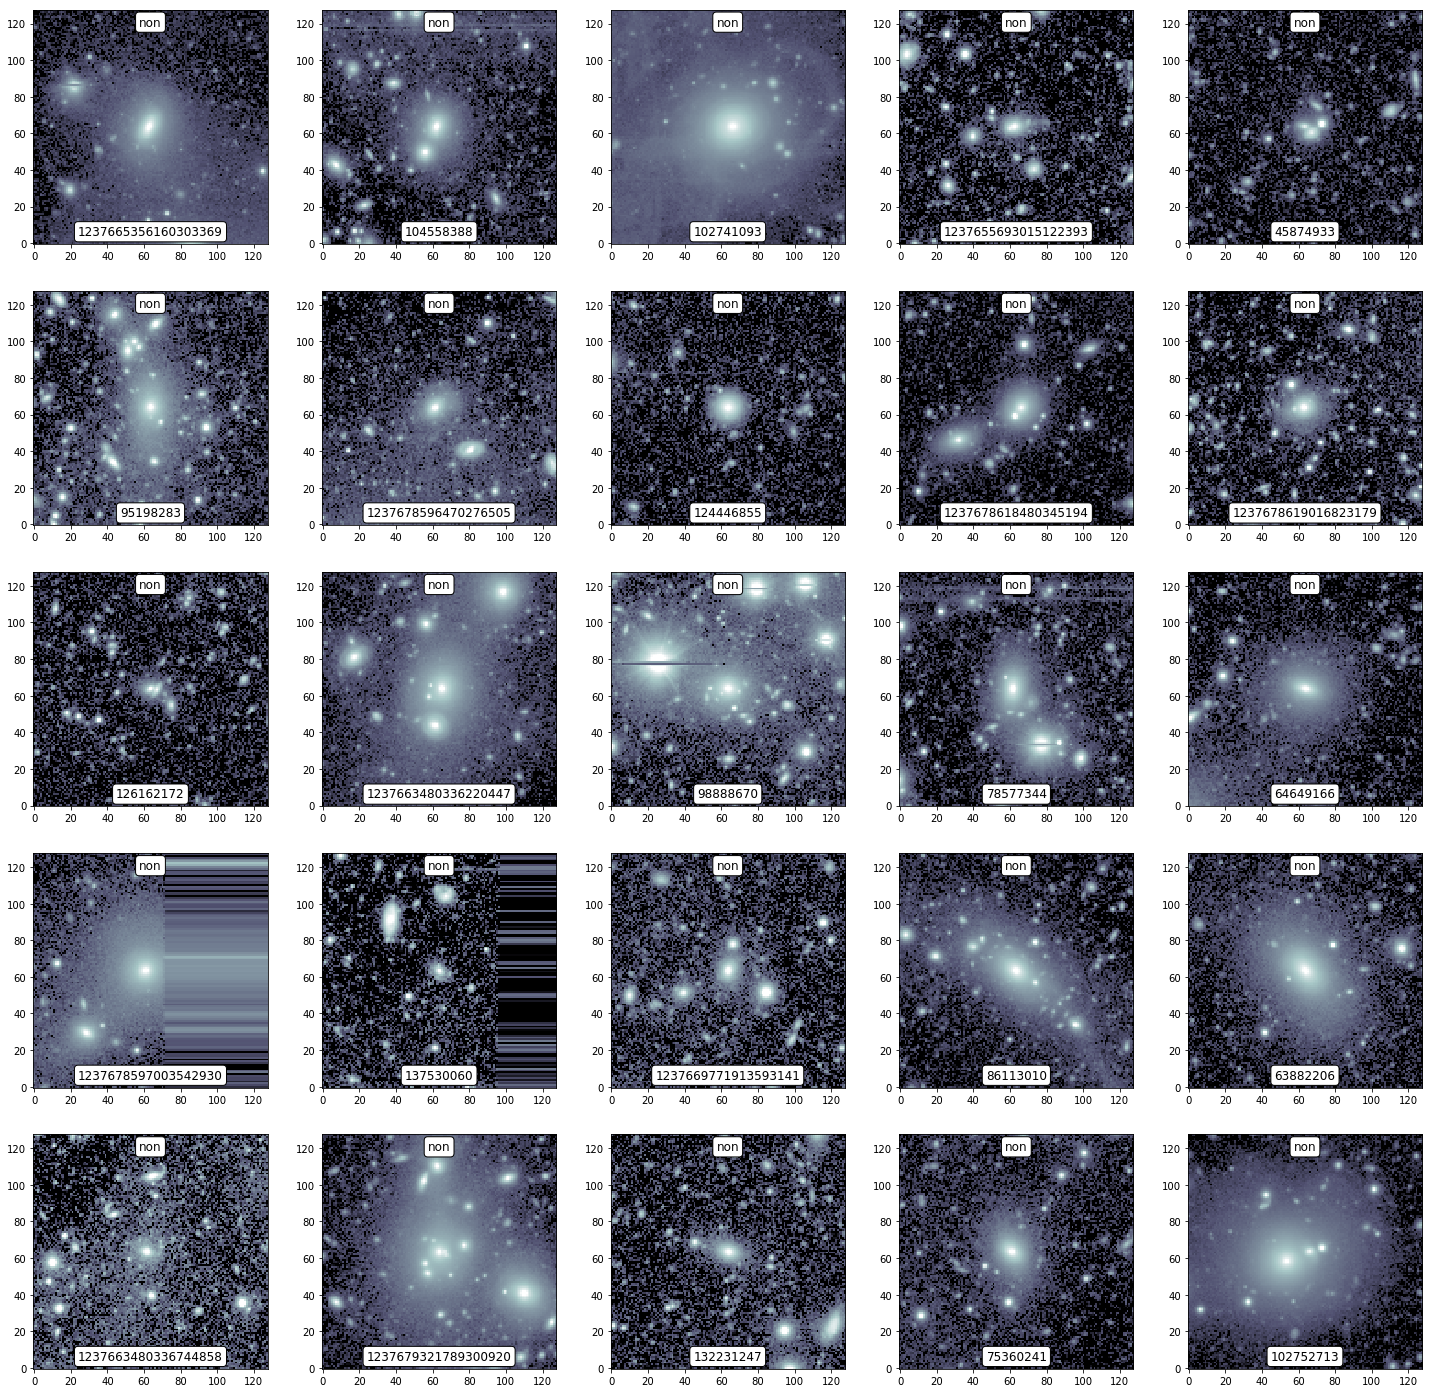

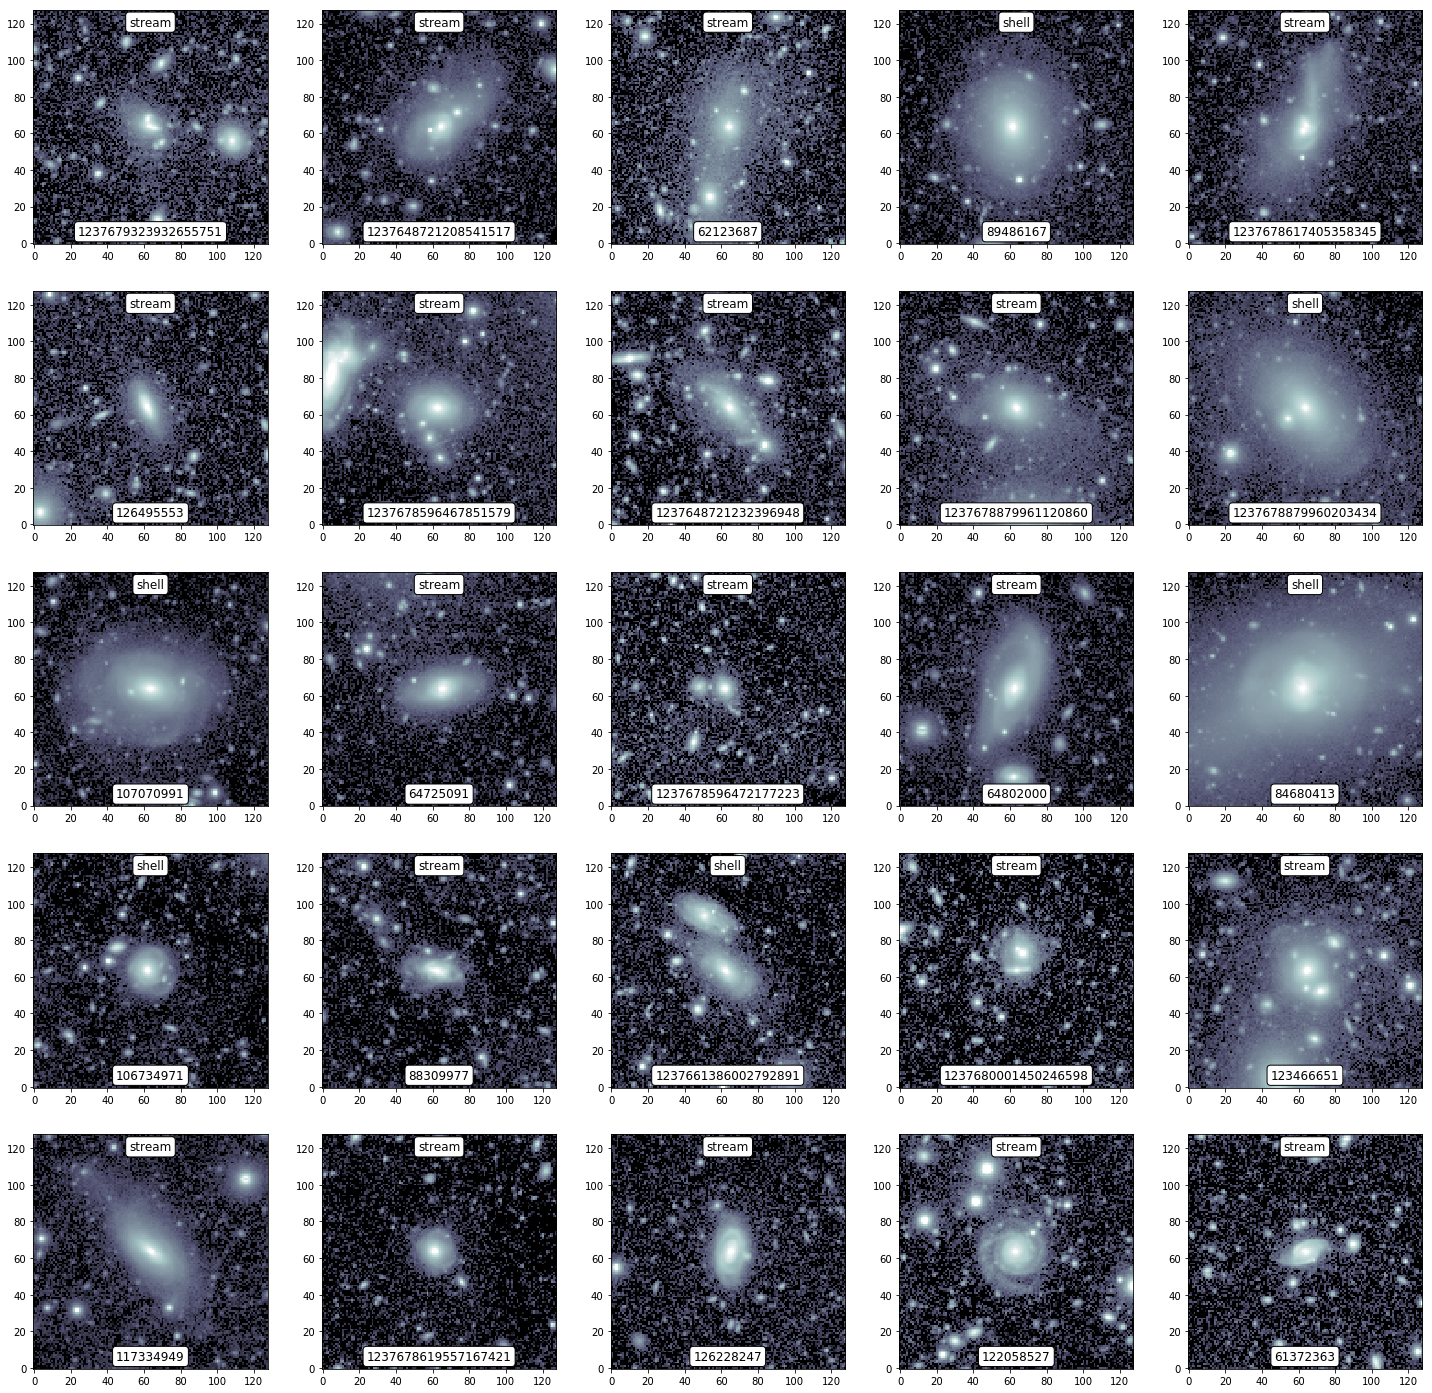

In [38]:
import matplotlib.pyplot as plt 

print('Negatives')
indices = np.argwhere(tar==0).flatten()
print(inp.shape,len(indices))
fig,axarr = plt.subplots(5,5,figsize=(25,25))
indices = np.random.choice(indices,25,replace=False)
for index,ax in zip(indices,axarr.flat):
    morphID = cat[index][1]
    objID = cat[index][0]
    ax.imshow(inp[index].reshape(128,128),vmin=0,vmax=1,origin='lower',cmap='bone')
    ax.text(0.5,0.025,'{}'.format(objID),transform=ax.transAxes,ha='center',va='bottom',fontsize=12,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax.text(0.5,0.975,'{}'.format(morphID),transform=ax.transAxes,ha='center',va='top',fontsize=12,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    
print('Positives')
indices = np.argwhere(tar==1).flatten()
print(inp.shape,len(indices))
fig,axarr = plt.subplots(5,5,figsize=(25,25))
indices = np.random.choice(indices,25,replace=False)
for index,ax in zip(indices,axarr.flat):
    morphID = cat[index][1]
    objID = cat[index][0]
    ax.imshow(inp[index].reshape(128,128),vmin=0,vmax=1,origin='lower',cmap='bone')
    ax.text(0.5,0.025,'{}'.format(objID),transform=ax.transAxes,ha='center',va='bottom',fontsize=12,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax.text(0.5,0.975,'{}'.format(morphID),transform=ax.transAxes,ha='center',va='top',fontsize=12,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

In [48]:
nRecords,dx,dy,nChannels = inp.shape
nClasses=len(classIDs)
#del new_inp,new_cat

batch_size = 32
epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 23
version = 0 
label = 'HSC-Subaru'
          
randomStates = [54321,]

for randomState in randomStates:

    modelFile = modelDir+'{}_Binary_RS-{}_v{}_{}.h5'
    historyFile = modelDir+'{}_Binary_RS-{}_v{}_{}_history.json'
    if os.access(modelFile.format(label,randomState,version,update),0): continue

    modelFile = modelFile.format(label,randomState,version,update)
    print('Model will save as: {}'.format(modelFile))
    historyFile = historyFile.format(label,randomState,version,update)
    print('History will save as: {}'.format(historyFile))

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid = md.train_test_split(inp, tar, cat, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test = md.train_test_split(inp_valid, tar_valid, cat_valid, test_size=valid_test_split, random_state=randomState)

    print(inp_train.shape)
    args = (dx,dy,nChannels)
    model = HSC_Subaru_CNN(args)
    
    model.summary()
    
    class_weight=balanced_class_weights(tar_train)
    
    print("Weights used:", class_weight)
    
    early_stopping = EarlyStopping(monitor='val_loss',patience=999,verbose=0,mode='auto')
    model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
              batch_size=batch_size,validation_data=[inp_valid,tar_valid],
              callbacks=[early_stopping],class_weight = class_weight) 
    
    model.save(modelFile)
    save_model_history(model=model,history_filename=historyFile)

#     out_train= np.array(model.predict([inp_train]))
#     out_valid= np.array(model.predict([inp_valid]))  
#     out_test=np.array(model.predict([inp_test]))

#     out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
#     out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
#     out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

#         model.save(modelFile)
#         save_model_history(model=model,history_filename=historyFile)

Model will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-54321_v0_23.h5
History will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-54321_v0_23_history.json
(4340, 128, 128, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 128, 128, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 32, 32, 64)        0         
________________

4340/4340 [==============================] - 2s 392us/step - loss: 0.0981 - acc: 0.9896 - val_loss: 1.0295 - val_acc: 0.7581
Epoch 43/100
4340/4340 [==============================] - 2s 394us/step - loss: 0.1085 - acc: 0.9857 - val_loss: 1.0467 - val_acc: 0.7871
Epoch 44/100
4340/4340 [==============================] - 2s 392us/step - loss: 0.1262 - acc: 0.9857 - val_loss: 0.9920 - val_acc: 0.7978
Epoch 45/100
4340/4340 [==============================] - 2s 393us/step - loss: 0.1587 - acc: 0.9783 - val_loss: 1.0588 - val_acc: 0.7344
Epoch 46/100
4340/4340 [==============================] - 2s 436us/step - loss: 0.1370 - acc: 0.9829 - val_loss: 1.0345 - val_acc: 0.7968
Epoch 47/100
4340/4340 [==============================] - 2s 391us/step - loss: 0.1248 - acc: 0.9866 - val_loss: 1.1221 - val_acc: 0.7914
Epoch 48/100
4340/4340 [==============================] - 2s 393us/step - loss: 0.1491 - acc: 0.9790 - val_loss: 0.9714 - val_acc: 0.7957
Epoch 49/100
4340/4340 [=======================

(40427, 128, 128, 1)
(40427,)
(40427, 7)
Negatives:
[0. 0. 0. ... 0. 0. 0.]
20010
0.0
0.0 0.0
0.0 1.0
0
327843840
Positives:
[1. 1. 1. ... 1. 1. 1.]
20417
20417.0
1.0 1.0
0.0 1.0
0


KeyboardInterrupt: 

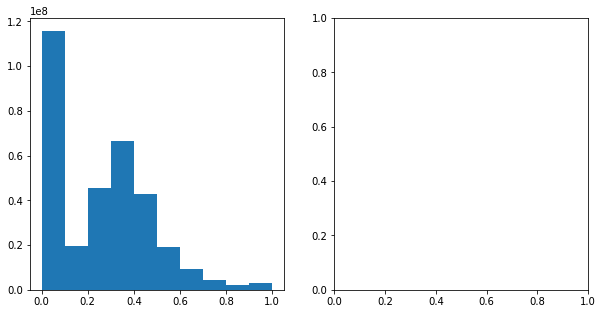

In [28]:
print(inp.shape)
print(tar.shape)
print(cat.shape)

print('Negatives:')
print(tar[:20010])
print(len(tar[tar==0]))
print(np.sum(tar[:20010]))
print(tar[:20010].min(),tar[:20010].max())
print(np.min(inp[:20010]),np.max(inp[:20010]))
print(len(inp_neg[np.isnan(inp_neg)]))
print(len(inp_neg.flat))

print('Positives:')
print(tar[20010:])
print(len(tar[tar==1]))
print(np.sum(tar[20010:]))
print(tar[20010:].min(),tar[20010:].max())
print(np.min(inp[20010:]),np.max(inp[20010:]))
print(len(inp_pos[np.isnan(inp_pos)]))


xedges = np.linspace(0,1,11)
widths = (xedges[1:]-xedges[:-1])
xcs = xedges[:-1]+widths/2.

fig,axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
tmp = inp[:20010]
H,xedges = np.histogram(tmp.flat,bins=xedges,density=False)
ax.bar(xcs,height=H,width=widths)

ax = axarr[1]
tmp = inp[20010:]
H,xedges = np.histogram(tmp.flat,bins=xedges,density=False)
ax.bar(xcs,height=H,width=widths)